In [1]:
import json
import os
import pandas
import numpy
import requests
import time
API_KEY = ''
with open('KEYS.txt', 'r') as file:
    API_KEY = file.read().strip()

## Multivariate Data Analysis Problem:

Last year was the best year ever for hackers, phishers, and scammers on public blockchain networks. An estimated $3.8 Billion was stolen, primarily from Decentralized Finance protocols and by North Korea-linked attackers. Developing an identity-based positive reputation score is one key tool needed to combat and prevent these attacks, and allowing the technology to flourish and grow.

Public blockchain networks are pseudonymous, meaning that while the real-world identity of a blockchain 'user' may not be known, all of their activities and every transaction that they publish to the blockchain network is publicly available. Similar to how although the exact identity of a pseudonymous author is not known, every piece of writing they publish under the pseudonymous identity can be aggregated and analyzed. 

Blockchains are state machines, meaning the system is described by the chain of its initial, intermediary, and final states. Each state is entirely described by the previous state of the system, and the sum of all 'transactions' in each block. A transaction in this context is a valid operation within the system that mutates the blockchain data structure in some way.

A blockchain 'identity' is thus an individuals public blockchain identifier (known as a public address), and all of the transactions that affect that public address (likely as the sender or recipient). A positive reputation score associated with a blockchain identity would be a metric that accurately identifies addresses that are likely to be non-malicious.

In this analysis, I seek to identify an initial heuristic for positive reputation that can be further refined and expanded into a more comprehensive model for postive reputation. The goal is to eventlually classify, with high precision, whether a submitted transaction is "honest" or "reputation inconclusive"


## Project Description:

What we are trying to identify with this project is a set of heuristics that, with extremely high confidence, will predict that a transaction  is "honest". In this context, honest means, that the transaction is not a malicious transaction. Examples of malicious transactions include the movement of funds in the procession of fraud, money laundering, hacks, scams, etc.

To identify whether or not an ethereum transaction is honest, we must examine the transaction metadata that is publicly available (and published in real time) on the blockchain network, as well as the additional metadata related to the transaction. For our purposes, transaction metadata includes the details on the sender, the recipient, the amount, the timestamp, and over. Related transaction metadata would include additional data related to the sender, recipient, and timestamp, such as the balance of the sending address, the balance of the receiving address, and other information.

Given that transaction data is in the form of a time series, it is important to clearly define the population and objective. The population of data that we are interested in is all transaction activity from the period 2021-04-01 to 2023-04-01. We choose this upper and lower bound on the period in consideration, because the transaction volume on the ethereum network is not normally distributed across the entire lifetime of the network. We want our period to capture activity reflective of the modern network usage, and to not overweight early transaction data that may not be relevant to modern network usage. Thus, we select a period of the two current years.

## Data Source:
The data we are using is provided by Allium, which is an enterprise grade blockchain data provider. Allium provides infrastructure to enterprises that needed institutional scale access to querying live blockchain datasets. Allium's data comes directly from the nodes that it runs on the networks, so we have confidence that the data is accurate. By the nature of blockchain networks, we can have confidence that there is no missing or non-standardized data. In order to import the data from Allium, I will first have to write the SQL within their query builder, on their website, and then either export the data via CSV download, or import directly via API call into this jupyter notebook.


In [2]:
from IPython.display import HTML

url = "https://embed.theblockcrypto.com/data/on-chain-metrics/ethereum/ethereums-adjusted-on-chain-volume-daily/embed"

iframe_code = f'<iframe src="{url}" width="100%" height="420" frameborder="0" allowfullscreen></iframe>'

HTML(iframe_code)

/Users/alexcullen/anaconda3/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Data Description:
A blockchain can be understood as basically a single data structure. The Structure is entirely comprised of a linear sequence of blocks. Each block has a number, beginning at 1 (the genesis block), and updating each time a new block is found. As of the writing of this post, there have been more than 780,000 blocks discovered. Each block contains a batch of transcations. Each transaction contains details on the sender and recipient, value, etc. Ethereum blockchain addresses have one of two classifications, they are either autonomous (smart contracts), or they Externally Owned Accounts. We are only concerned with transactions initiated by Externally Owned Accounts, for the purposes of identifying "honest" transaction originators.

Additionally Allium has maintains a database table called "Ethereum Assets", which enriches the existing metadata to provide useful intelligence on things like current account balance, or time of last activity.

Together, the datasets that we are interested in are: Transactions, Blocks, Contracts, and Assets

## APA citation for datasets:
Allium.so. (n.d.). Ethereum Raw Transactions [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Raw Blocks [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Raw Contracts [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Assets [Data set]. Allium.so. Retrieved from https://allium.so/

## Features available in a blockchain transaction
| Column Name       | Description	                                                                                                                                                                                         | Example                                                             |
|:--------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------|
| block_timestamp      | The time when the block that contains this transaction was included on the blockchain.                                                                                                               | 2022-09-16 04:59:59                                                 |
| block_number	                   | The length of the chain, in blocks                                                                                                                                                                   | 15543975                                                            |
| block_hash	| Unique identifier of the block that includes this transaction.	                                                                                                                                      | 0xe3eb6f24b34ab179646608ca100a3cd1d2fd1144f83544d029c0352429371b6d  |
| hash	| Unique identifier of a transaction.                                                                                                                                                                  | 	0x9068357001dc45c59a0c0383860f25fd64daeef205f723c5cbd980f280baca38 |
|from_address	| The address of the sending party of this transaction.                                                                                                                                                | 	0x7e63870ac9cb1491928e3c8922c19b2595331ac9                         |
|to_address	| The address of the receiving party of this transaction (could be a contract address). | 	0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45                         |
|value	| The amount of ether sent in this transaction, in wei.                                                                                                                                                | 	341813481343000822                                                 |
|receipt_status	| Success status of the transaction. Either 1 (success) or 0 (failure).	                                                                                                                               | 1                                                                   |
|gas	| The maximum amount of gas allocated for this transaction in wei.	                                                                                                                                    | 209392                                                              |
|gas_price	| Cost per unit of gas specified by the transaction in wei. The higher the gas price, the higher chance of getting included in a block.	                                                               | 6545492045                                                          |
|receipt_gas_used	| Gas consumed by the transaction in wei.	                                                                                                                                                             | 150272                                                              |
|max_fee_per_gas	| The maximum fee per gas that the transaction sender is willing to pay for this transaction (introduced in EIP1559)	                                                                                  | 10293849223                                                         |
|max_priority_fee_per_gas	| The maximum fee per gas the transaction sender is willing to give to validators (Proof of Stake) or miners (Proof of Work) to incentivize them to include their transaction (introduced in EIP1559)	 | 2000000000                                                          |
|transaction_index	| The position of this transaction in the block that it belongs to. The first transaction has index 0.                                                                                                 | 	62                                                                 |
|nonce	| The transaction nonce, unique to the wallet                                                                                                                                                          | 	203                                                                |

## Data Cleaning and EDA:
Our objective is to define one or more simple heuristics that can identify honest transactions with high accuracy. Total transaction count by different users is also not normally distributed. The small minority submit the vast majority of transactions. It's import for our sample to be representative of the population of unique transaction senders, and to not overweight a single individual who might send thousands or even hundreds of thousands of transactions.

To do this, we will stratify our sample and randomly select within the strata. Before we do that, we must complete some exploratory data analysis to determine what appropriate stratification for the population of data might be.

However, because this is time series data with hundreds of millions of records (if not more), we need to summarize the data such that it is possible for a query to execute in reasonable time. To begin, let's determine the total number of transactions and unique addresses transacting in the period. We will summarize this data in intervals, and observe the resulting histogram to determine the portion of transactions that fall within arbitrary buckets.

Because the dataset is too large to directly import into the jupyter notebook, the below output is the result of an SQL query run on the Allium platform.

## Population Sizing
First we will get the population of all transactions, then we will filter out all transactions originated by entities other than Externally Owned Accounts. Then we will filter again by distinct originating addresses to arrive at our population of Unique Addresses and transactions in the period.

In [3]:
import pandas as pd
data = [{"filter":"Total Transactions","count":852808230},
        {"filter":"Unique Senders", "count": 77212235},
        {"filter":"Unique Human Senders", "count": 52301378}]
df = pd.DataFrame(data)
df

,filter,count
0,Total Transactions,852808230
1,Unique Senders,77212235
2,Unique Human Senders,52301378


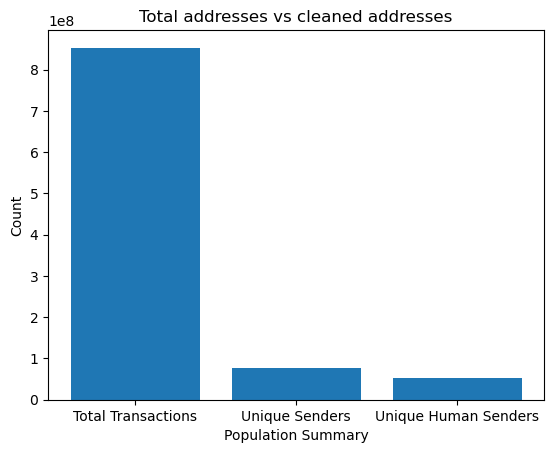

In [4]:
import matplotlib.pyplot as plt

filter = [item["filter"] for item in data]
count = [item["count"] for item in data]

plt.bar(filter, count)
plt.xlabel("Population Summary")
plt.ylabel("Count")
plt.title("Total addresses vs cleaned addresses")
plt.show()


## Current Balance Data Visualization

In [5]:

data = [{"eth_holdings":"0-0.1 ETH","address_count":48062697},{"eth_holdings":"0.1-1 ETH","address_count":1659033},{"eth_holdings":"1-10 ETH","address_count":603474},{"eth_holdings":"10-100 ETH","address_count":151623},{"eth_holdings":">100 ETH","address_count":25693}]
df = pd.DataFrame(data)

In [6]:
df

,eth_holdings,address_count
0,0-0.1 ETH,48062697
1,0.1-1 ETH,1659033
2,1-10 ETH,603474
3,10-100 ETH,151623
4,>100 ETH,25693


In [7]:
df.columns

Index(['eth_holdings', 'address_count'], dtype='object')

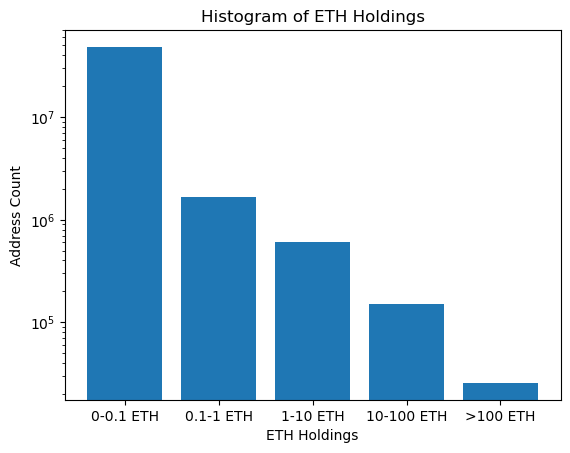

In [8]:
import matplotlib.pyplot as plt

eth_holdings = [item["eth_holdings"] for item in data]
address_count = [item["address_count"] for item in data]

plt.bar(eth_holdings, address_count)
plt.xlabel("ETH Holdings")
plt.ylabel("Address Count")
plt.yscale("log")
plt.title("Histogram of ETH Holdings")
plt.show()

The above histogram shows the distribution of current ethereum balances (in log scale) for all wallets that transacted in the period .

## Total transaction count data visualization


In [9]:
data=[{"txn_count":"0. 0","address_count":74701}
      ,{"txn_count":"b. 1-10 txns","address_count":211109}
      ,{"txn_count":"c. 11-100 txns","address_count":191531}
      ,{"txn_count":"d. 101-1000 txns","address_count":114627}
      ,{"txn_count":"e. >1000 txns","address_count":21348}
      ,{"txn_count":"sum","address_count":613316}]
df = pd.DataFrame(data)
df

,txn_count,address_count
0,0. 0,74701
1,b. 1-10 txns,211109
2,c. 11-100 txns,191531
3,d. 101-1000 txns,114627
4,e. >1000 txns,21348
5,sum,613316


Text(0.5, 1.0, 'Histogram of Transaction Counts')

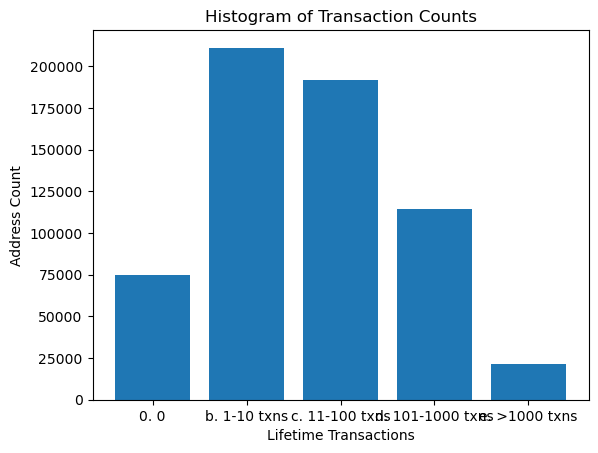

In [10]:
import matplotlib.pyplot as plt

tx_counts = [item["txn_count"] for item in data[:-1]]
address_count = [item["address_count"] for item in data[:-1]]

plt.bar(tx_counts, address_count)
plt.xlabel("Lifetime Transactions")
plt.ylabel("Address Count")
plt.title("Histogram of Transaction Counts")

A histogram of the lifetime transaction count of all transacting addresses in the period

In [11]:
from IPython.display import Image

# Replace 'image_file_path' with the relative path of your image file
image_file_path = 'path/to/your/image.png'

# Display the image in the notebook
Image(filename='img/Unique_Address_Count.png')

FileNotFoundError: [Errno 2] No such file or directory: 'img/Unique_Address_Count.png'

## Sample Size Selection:
We use Cochran's formula = Z^2 * p ( 1 - p)/ MoE^2. This would give us an extremely conservative estimate
Z = 3 (there is an extremely high cost to being wrong, so we want our metrics to be > 99% accurate
p = .5 (We do not know the actual probability of a transaction sender being honest, so we take the most conservative estimate)
MoE = .01 (We want our precision to, again, be very high, because the cost of error is lost revenue, and therefore should be minimized to the degree possible)

A comment on error. Our concern would be that we determine a transaction to be a good transaction when, in fact, it was a malicious transaction.

1.96^2 * (.5*(1-.5))/(.01^2) = 9604

For our sample, we will then randomly sample a total of 7500 addresses from a stratified popualtion

In [32]:
sample_addresses = pd.read_csv('./sample_addresses.csv')
# Define the batch size
batch_size = 1000

# Get the total number of batches
total_batches = (len(sample_addresses) + batch_size - 1) // batch_size
batches = []
# Loop through each batch
for batch_number in range(total_batches):
    # Get the start and end indices for slicing
    start_index = batch_number * batch_size
    end_index = start_index + batch_size

    # Get the current batch of IDs
    batch_ids = sample_addresses.from_address[start_index:end_index]
    batch_id_str = ','.join(f"'{id}'" for id in batch_ids)
    batches.append(batch_id_str)
batches

["'0x0d5a4d9ef11d4b69bb1b3eb5bb72312f41e6a7e5','0x631e52873b49d4ff38d7585f89177152a836294b','0x5e11131bfe64dcf7d9a499a944886b01ab556853','0xa4ec3b0e86bf9b831e433c67cd558adfcdf41cf5','0xa45b5c7ff401f037796c4dcf2b82b92178c7605f','0x25954fd00680f59370ed00fe66ebbedad495a389','0xf088e62fd10a5a3e5dace31a80b02a5d6cafd67c','0xe8f0bfe6b741118a7cc81f75add0072e3c404b7c','0x268baa90b9679f248e4d95dac8f01cf037d27b56','0xeb1687a3ceb676352d38a97978e67cc39fd0265e','0x2902b6c60264ef3b8c902a4529b7fe2edc098d98','0xfd3720996348d423cff51c23853e4094b61588ec','0x376067d5bb7507b877a169fe210bc47d56d5c526','0xc0026e64b434d2d1bc6f587657ac0aa36bf1ba42','0x9e19f33c1ae95fe1513ff74d4ac7c77e32ebb3d7','0x33a2cb4725ee1f0bae949293f7cd044f35bb391e','0x063dc101f5aee3cba8c03e3bea7f5d0785c03abd','0x24a3040ea0e6990a122090a0a453cd40b299c0f1','0xad78132df25453e805ff36c79c1d75f5a4b2cf16','0x66bc1ec01d0abb3494b6f5c7a2714470635b8534','0x4a0bb6b762239cc793f770c67d73196ee6d856e7','0xac48a6931c813bbb0a5257a3d974a9667d5549b5','0x87d73

In [58]:

inset = set(transaction_data['from_address']).union(set(transaction_data['to_address']))
len(inset)
retryAddresses = list(set(sample_addresses.from_address).difference(inset))
# Define the batch size
batch_size = 1

# Get the total number of batches
total_batches = (len(retryAddresses) + batch_size - 1) // batch_size
retryBatches = []
# Loop through each batch
for batch_number in range(total_batches):
    # Get the start and end indices for slicing
    start_index = batch_number * batch_size
    end_index = start_index + batch_size

    # Get the current batch of IDs
    batch_ids = retryAddresses[start_index:end_index]
    batch_id_str = ','.join(f"'{id}'" for id in batch_ids)
    retryBatches.append(batch_id_str)
retryBatches
# Get the total number of batches

["'0x473300df21d047806a082244b417f96b32f13a33'"]

In [59]:

QUERY_ID = "ieuP4ZH63m1hKjOZyvuW"
run_ids = []
all_results = []
successful_runs = []
failed_runs = []
no_results = []
# Get the total number of batches
#total_batches = (len(df.from_address) + batch_size - 1) // batch_size
# Loop through each batch
for batch in retryBatches:
    response = requests.post(
        f"https://api.allium.so/api/v1/explorer/queries/{QUERY_ID}/run-async",
        json={"parameters":
                  {"sampleAddresses": batch
                  },
                "run_config": {"limit": 250000}},
        headers={"X-API-Key": API_KEY},
        timeout=10,
    )
    try:
        print(response.status_code, response.text)
        run_id = response.json()["run_id"]
        print(f"Query run created with ID: {run_id}")
        run_ids.append(run_id)
    except json.JSONDecodeError as e:
        print(e)
        failed_runs.append(run_id)

for run_id in run_ids:
    polling_interval, start, timeout = 1, time.time(), 20 * 60  # 20min timeout
    while time.time() < start + timeout:
        run_status = ''
        response = requests.get(
            f"https://api.allium.so/api/v1/explorer/query-runs/{run_id}/status",
            headers={"X-API-Key": API_KEY},
            timeout=10,
        )
        try:
            run_status = response.json()
        except json.JSONDecodeError as e:
            failed_runs.append(run_id)
            break
        if run_status not in ["created", "queued", "running"]:
            break
        print(f"Current status: {run_status}. Waiting {polling_interval}s...")
        time.sleep(polling_interval)

    if run_status == "success":
        successful_runs.append(run_id)
        response = requests.get(
            f"https://api.allium.so/api/v1/explorer/query-runs/{run_id}/results?f=json",
            headers={"X-API-Key": API_KEY},
        )
        results = response.json()
        # Convert the API response data to a DataFrame
        new_data = pd.DataFrame(results['data'])

        # Concatenate the empty DataFrame with the new data, creating new columns as needed
        transaction_data = pd.concat([transaction_data, new_data], axis=0, ignore_index=True)
        all_results.append(results)
        print(
            f"Query returned {len(results['data'])} rows, with "
            f"fields: {', '.join(column.get('name') for column in results['meta']['columns'])}"
        )

    elif run_status == "failed":
        failed_runs.append(run_id)
        response = requests.get(
            f"https://api.allium.so/api/v1/explorer/query-runs/{run_id}/error",
            headers={"X-API-Key": API_KEY},
        )
        error_message = response.json()
        print(
            f"Query failed with error: {error_message}"
        )
    else:
        no_results.append(run_id)
        print(f"Query run finished with status: {run_status}. No results.")
print(transaction_data.shape)
transaction_data.head()

200 {"run_id":"ZqMxOIDiBb24PQUj6rBi"}
Query run created with ID: ZqMxOIDiBb24PQUj6rBi
Current status: queued. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: ru

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [26]:
# Specify the directory path
dir_path = './transactionData'

# List all files in the directory
file_names = os.listdir(dir_path)

# Loop through the files
for file_name in file_names:
    # Create the full file path by joining the directory path and the file name
    file_path = os.path.join(dir_path, file_name)
    if file_name.startswith('.'):
        continue
    # Check if it's a file (and not a directory)
    if os.path.isfile(file_path):
        # Open and read the file
        with open(file_path, 'r') as file:
            print(f'reading file {file_path}')
            try:
                file_content = file.read()
            except Exception as e:
                print(file_path, e)
            json_data = json.loads(file_content)
            print(f"number of rows = {len(json_data['data'])}")
            new_data = pd.DataFrame(json_data['data'])
            transaction_data = pd.concat([transaction_data, new_data], axis=0, ignore_index=True)
            # Pr
transaction_data.head()

reading file ./transactionData/Get Transaction Data - XJwunSI9ASKapRKveZA2.json
number of rows = 20575
reading file ./transactionData/Get Transaction Data - ErQOGActbZmq1CJAu1G4.json
number of rows = 9118
reading file ./transactionData/Get Transaction Data - 17Z6OwchngPd0BW44hod.json
number of rows = 11198
reading file ./transactionData/Get Transaction Data - 6HQBrLxYDOyqRGeJYVY3.json
number of rows = 15038
reading file ./transactionData/Get Transaction Data - 8ZQH7MeqM4Zg3mfnf6AL.json
number of rows = 11729
reading file ./transactionData/Get Transaction Data - kKZHqNuAwAuZ28LByGP2.json
number of rows = 13171
reading file ./transactionData/Get Transaction Data - sgIZq0IBCEwE9QRYSB1e.json
number of rows = 14629
reading file ./transactionData/Get Transaction Data - 09Mug8619sEotCMMATZj.json
number of rows = 12350
reading file ./transactionData/Get Transaction Data - 4OgaVNyFRwlJzCiY5mhN.json
number of rows = 24222


,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x04c7ad20d35b76145dbd5ba701f55fb793007bc9bad6...,109990,74,0x8f22f2063d253846b53609231ed80fa571bc0c8f,0x6321495b415c873d4f04b84ece0519754788edad,1494111550000000000,207128,135000000000,0x,3674628,...,None,None,1.0,2021-03-20T09:42:21,12074960,0x48a2fc67cdc435b09117297d049eba5e04909be8872a...,NaN,NaN,NaN,1.350000e+11
1,0x0a418e5f6b2246f7f1ba4ad74b8f50863ac24ca9eaac...,0,9,0xadee4b0890053fc15aed0990d867f5062184ebf7,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,1434171200000000000,42000,64000000000,0x,706756,...,None,None,1.0,2021-05-02T18:10:52,12356270,0x92e261d44236134c821492df1cca4d04fe61ba76cbc6...,NaN,NaN,NaN,6.400000e+10
2,0x86a8f415bbf3eb6f8621daea85b96918efabb9a4cd65...,177,150,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,212765,23000000000,0x38ed1739000000000000000000000000000000000000...,13697132,...,None,None,1.0,2021-05-02T10:36:21,12354235,0x202226ebc999ab15d52b3627d0b55989904c8414850f...,NaN,NaN,NaN,2.300000e+10
3,0xbdd7c7c1b8bc7b6c7ed4ec56074ebae3e10e513e1203...,157,57,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,204264,101000001459,0x38ed1739000000000000000000000000000000000000...,5340632,...,None,None,1.0,2021-03-21T08:53:20,12081144,0xff7d5076b0e7b611ea5bf04704fb0d209313c5380959...,NaN,NaN,NaN,1.010000e+11
4,0x1908da7917c43e7523501042054922d2472708283a6e...,154,48,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0xb1f871ae9462f1b2c6826e88a7827e76f86751d4,0,48726,101000000000,0x095ea7b30000000000000000000000007a250d5630b4...,2371573,...,None,None,1.0,2021-03-21T08:24:53,12081028,0xee9ee72d6fbfc2fbe36afd4c935870a699e2137482ef...,NaN,NaN,NaN,1.010000e+11


In [66]:
transaction_data.to_csv('transactions.csv')
td = pd.read_csv('transactions.csv')
td.shape

(156536, 22)

Population Stratification:
We are interested in determining the stratification of population

In [ ]:
import requests
import pandas as pd

API_KEY = "5uxdqImRdstj7NoqW8c0kuQWtlYkouWLzMHADiwvrCDxogFy6gB2LEtQLboq5qOrnwxym8C1pBZmRO1FIr4I8Q"

response = requests.post(

    "https://api.allium.so/api/v1/explorer/queries/pDveVdd1X7jzrl07r2wH/run",

    json={},

    headers={"X-API-Key": "5uxdqImRdstj7NoqW8c0kuQWtlYkouWLzMHADiwvrCDxogFy6gB2LEtQLboq5qOrnwxym8C1pBZmRO1FIr4I8Q"},

)


run_id = response.json()["run_id"]

while True:
    response = requests.get(
        f"https://api.allium.so/api/v1/explorer/query-runs/{run_id}/status",
        headers={"X-API-Key": API_KEY},
    )
    run_status = response.json()
    if run_status == "success":
        break
    elif run_status == "failed" or run_status == "canceled":
        raise f"Failed with run status: {run_status}"

response = requests.get(
    f"https://api.allium.so/api/v1/explorer/query-runs/{run_id}/results?f=json",
    headers={"X-API-Key": API_KEY},
)
dict_contents = response.json()
df = pd.DataFrame.from_dict(dict_contents['data'])

In [ ]:
len(response.json()['data'])

In [ ]:
import requests

response = requests.post(
    f"https://api.allium.so/api/v1/explorer/queries/L3lwyn29An71VIM9TGwg/run",
    json={
        "parameters": {},
        "run_config": {
            "limit": 1000,
        }
    },
    headers={"X-API-Key": "5uxdqImRdstj7NoqW8c0kuQWtlYkouWLzMHADiwvrCDxogFy6gB2LEtQLboq5qOrnwxym8C1pBZmRO1FIr4I8Q"},
)

print(response.json())

In [ ]:
len(response.json()['data'])